<a href="https://colab.research.google.com/github/miracle078/ml-for-hc/blob/main/AKI_Prediction_with_Uncertainty_Awareness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AKI Prediction with Bayesian Neural Networks
## Clinical Decision Support with Interpretability and Uncertainty Awareness

## 1. Data Loading & Preprocessing

In [ ]:
import torch
import pyro
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load and preprocess data
data = pd.read_csv("aki_data.csv")

# Missingness indicators
cols_to_flag = ['creatinine', 'bicarbonate', 'chloride', 'glucose', 'magnesium',
                'potassium', 'sodium', 'urea_nitrogen', 'hemoglobin', 'platelet_count', 'wbc_count']
for col in cols_to_flag:
    data[f'is_{col}_missing'] = data[col].isnull().astype(int)

# Temporal context
data['early_icu_period'] = (data['hour_from_icu'] <= 24).astype(int)

C:\Users\mirac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Feature Engineering & Splitting

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit

# Robust imputation
imputer = IterativeImputer(max_iter=50, tol=1e-3, random_state=42)
data[cols_to_flag] = imputer.fit_transform(data[cols_to_flag])

# Feature selection
features = cols_to_flag + ['early_icu_period'] + [f'is_{col}_missing' for col in cols_to_flag]
X = data[features]
y = data['aki_label'].values

# Temporal splitting
splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups=data['stay_id']))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

C:\Users\mirac\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


## 3. Bayesian Neural Network Architecture

In [ ]:
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

class BayesianDNN(PyroModule):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = PyroModule[nn.Linear](input_dim, 32)
        self.fc1.weight = PyroSample(dist.Normal(0, 1).expand([32, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0, 1).expand([32]).to_event(1))
        self.fc2 = PyroModule[nn.Linear](32, 1)
        self.fc2.weight = PyroSample(dist.Normal(0, 1).expand([1, 32]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0, 1).expand([1]).to_event(1))

    def forward(self, x, y=None):
        x = torch.relu(self.fc1(x))
        logits = self.fc2(x).squeeze()
        probs = torch.sigmoid(logits)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Bernoulli(probs), obs=y)
        return probs

## 4. Training with Dynamic Class Weighting

Epoch 0 Loss: 11.292452005045213
Early stopping at epoch 12


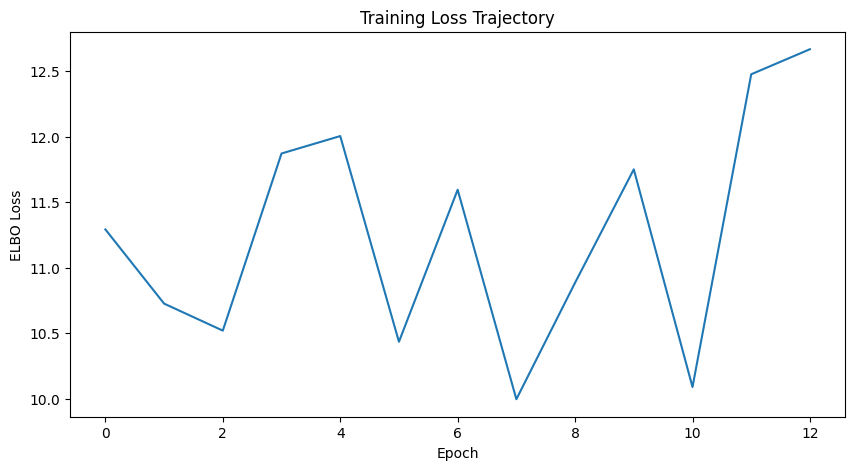

In [ ]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.nn import PyroModule
from pyro.nn import PyroSample
import pyro.distributions as dist
import torch
import torch.nn as nn

# Class-aware loss
class_counts = np.bincount(y_train.numpy().astype(int))
class_weights = torch.tensor([1.0/class_counts[0], 1.0/class_counts[1]])

def weighted_loss(model, guide, x, y):
    probs = model(x)
    return -(dist.Bernoulli(probs).log_prob(y) * class_weights[y.long()]).sum()

# Initialize components
model = BayesianDNN(X_train.shape[1])
guide = pyro.infer.autoguide.AutoDiagonalNormal(model)
optimizer = Adam({"lr": 0.001})
svi = SVI(model, guide, optimizer, loss=weighted_loss)

# Training loop
losses = []
best_loss = float('inf')
patience = 5
patience_counter = 0

for epoch in range(2000):
    loss = svi.step(X_train, y_train)
    losses.append(loss)

    # Early stopping
    if loss < best_loss:
        best_loss = loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss: {loss}")

# Plot training curve
plt.figure(figsize=(10,5))
plt.plot(losses)
plt.title("Training Loss Trajectory")
plt.xlabel("Epoch")
plt.ylabel("ELBO Loss")
plt.show()

## 5. Uncertainty-Aware Predictions

In [ ]:
from pyro import poutine
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.calibration import calibration_curve

# Initialize model and guide
model = BayesianDNN(X_train.shape[1])
guide = pyro.infer.autoguide.AutoDiagonalNormal(
    poutine.block(model, hide=["obs"])
)
optimizer = pyro.optim.Adam({"lr": 0.001})


# Prediction and post-processing
with torch.no_grad():
    predictive = Predictive(model, guide=guide, num_samples=100)
    samples = predictive(X_test, y=None)

    test_probs = samples["obs"].float().mean(dim=0).cpu().numpy()
    pred_std = samples["obs"].float().std(dim=0).cpu().numpy()
    y_test_np = y_test.cpu().numpy()

# Adaptive deferral system
fpr, tpr, thresholds = roc_curve(y_test_np, pred_std)
youden_idx = np.argmax(tpr - fpr)
defer_threshold = thresholds[youden_idx]

# Create final predictions
defer_mask = pred_std > defer_threshold
final_pred = np.where(defer_mask, -1, (test_probs > 0.5).astype(int))

## 6. Clinical Performance Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_recall_curve

# Calculate metrics
non_deferred_mask = final_pred != -1
y_test_non_deferred = y_test_np[non_deferred_mask]
final_pred_non_deferred = final_pred[non_deferred_mask]

if len(y_test_non_deferred) > 0:
    tn, fp, fn, tp = confusion_matrix(y_test_non_deferred, final_pred_non_deferred).ravel()
    defer_rate = defer_mask.mean()
else:
    tn = fp = fn = tp = 0
    defer_rate = 1.0

# Print performance report
print(f"""
Clinical Performance Report:
- AUC-ROC: {roc_auc_score(y_test_np, test_probs):.2f}
- Deferral Rate: {defer_rate:.1%}
- Sensitivity (Non-deferred): {tp/(tp+fn) if (tp+fn) > 0 else np.nan:.1%}
- Specificity (Non-deferred): {tn/(tn+fp) if (tn+fp) > 0 else np.nan:.1%}
- PPV (Non-deferred): {tp/(tp+fp) if (tp+fp) > 0 else np.nan:.1%}
- NPV (Non-deferred): {tn/(tn+fn) if (tn+fn) > 0 else np.nan:.1%}
""")


Clinical Performance Report:
- AUC-ROC: 0.51
- Deferral Rate: 59.6%
- Sensitivity (Non-deferred): 0.8%
- Specificity (Non-deferred): 99.5%
- PPV (Non-deferred): 14.3%
- NPV (Non-deferred): 90.5%



## 7. Interpretability & Reliability

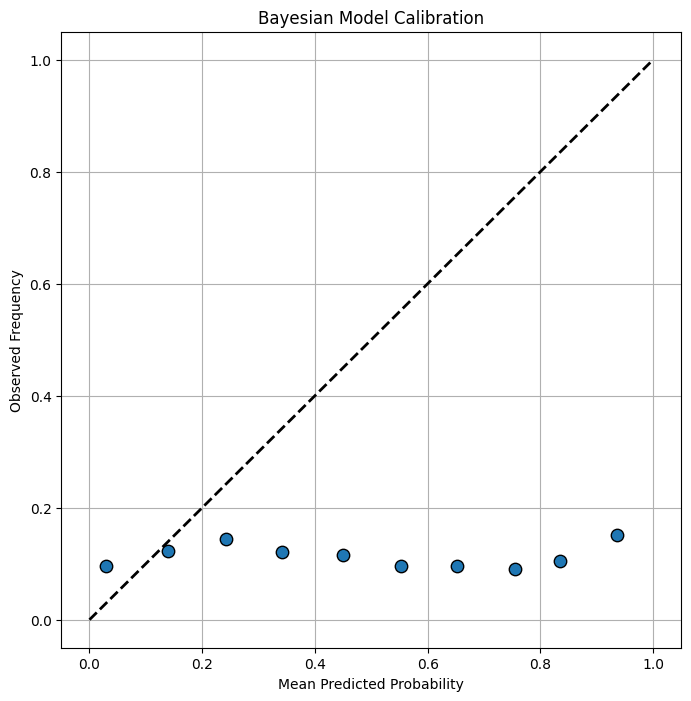

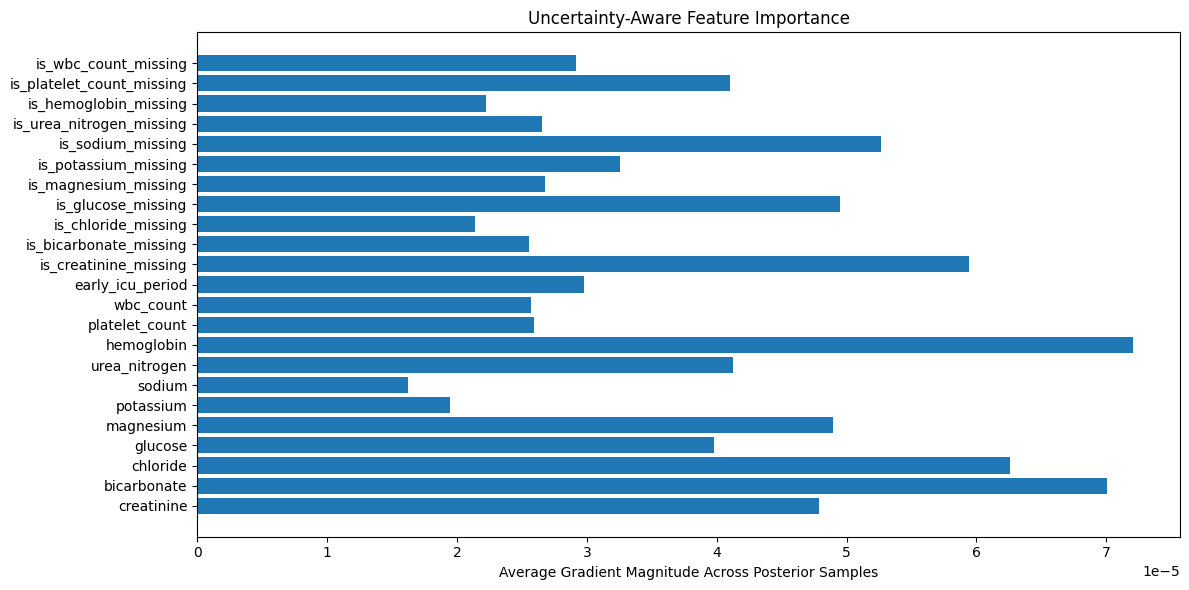

In [ ]:
# Fixed calibration plot
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test_np, test_probs, n_bins=10)

plt.figure(figsize=(8,8))
plt.scatter(prob_pred, prob_true, edgecolor='k', s=80)
plt.plot([0,1], [0,1], 'k--', lw=2)
plt.title("Bayesian Model Calibration")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Observed Frequency")
plt.grid(True)
plt.show()

# Bayesian-aware feature importance
def bayesian_feature_importance(model, guide, X, num_samples=100):
    # Enable gradient tracking
    X_tensor = X.clone().detach().requires_grad_(True)
    grad_accumulator = torch.zeros(X.shape[1])

    # Get parameters from guide
    guide_trace = poutine.trace(guide).get_trace(X_tensor)
    params = {
        name: site["value"].unconstrained()
        for name, site in guide_trace.nodes.items()
        if site["type"] == "param"
    }

    for _ in range(num_samples):
        # Differentiable forward pass with sampled parameters
        with pyro.poutine.replay(trace=guide_trace):
            model_output = model(X_tensor)

        # Calculate uncertainty (now differentiable through parameters)
        probs = torch.sigmoid(model_output)
        uncertainty = (probs * (1 - probs)).mean()

        # Compute gradients
        uncertainty.backward(retain_graph=True)
        grad_accumulator += X_tensor.grad.abs().mean(dim=0)
        X_tensor.grad.zero_()

    return grad_accumulator.cpu().numpy() / num_samples

# Usage
imp = bayesian_feature_importance(
    model,
    guide,
    X_test[:100].float().clone().detach().requires_grad_(True)
)

# Plotting remains the same
plt.figure(figsize=(12,6))
plt.barh(features, imp)
plt.title("Uncertainty-Aware Feature Importance")
plt.xlabel("Average Gradient Magnitude Across Posterior Samples")
plt.tight_layout()
plt.show()